In [1]:
from asr import ASR
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mne.io.read_raw_edf??
from numpy import genfromtxt

data_path = os.getcwd()+'/Raw/'
data_file = 'record-[2020.07.02-18.14.02].csv'
mat_fname = os.path.join(data_path, data_file)

data = genfromtxt(mat_fname, delimiter=',')
data = np.nan_to_num(data, copy = False)
#record-[2020.07.02-18.14.02].csv


In [3]:
np.shape(np.mean(data[1:,:],axis = 0))

(417217,)

In [4]:
#data[1:,:] -= np.mean(data[1:,:], axis = 0)

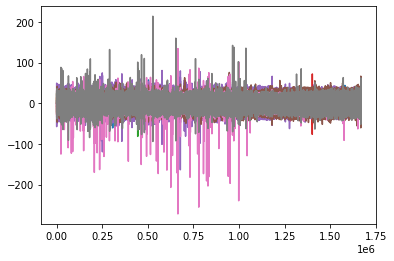

In [5]:
plt.plot(data[0,:],data[1:,:].T);

In [6]:
#LOADING DATA
#---------------
#Get data path and load data

ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
sfreq=250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq,  ch_types='eeg')
raw = mne.io.RawArray(data[1:,:], info)


Creating RawArray with float64 data, n_channels=8, n_times=417217
    Range : 0 ... 417216 =      0.000 ...  1668.864 secs
Ready.


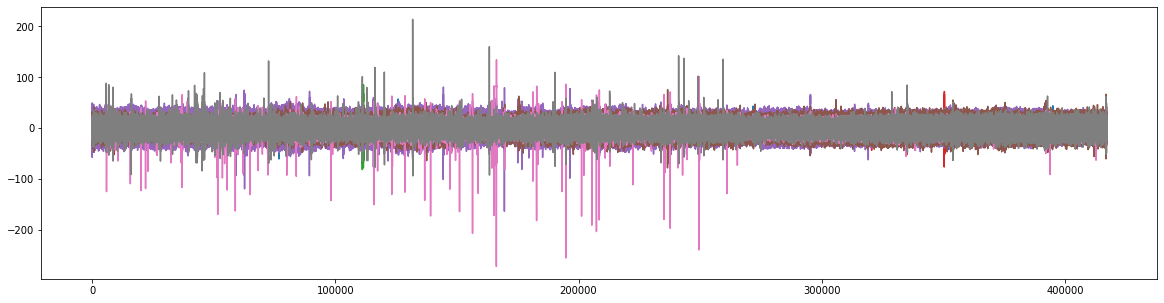

In [7]:
#plot raw data
plt.figure(figsize=(20,5))
plt.plot(raw.get_data().T);

In [8]:
#PREPROCESSING
#---------------

In [9]:
#Seperate calibration and recording
raw_calib = raw.copy()
raw_calib.crop(tmax=60.)
raw.crop(tmin=60.)


<RawArray | 8 x 402217 (1608.9 s), ~24.6 MB, data loaded>

In [10]:
#initialize Artifact Subspace Reconstruction
asr = ASR()

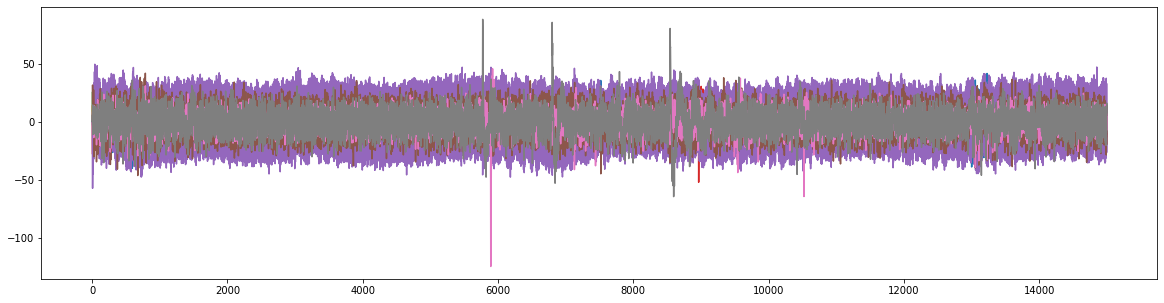

In [11]:
#plot calibration data

x_c = asr.clean_windows(raw_calib)
plt.figure(figsize=(20,5))
plt.plot(x_c.T);


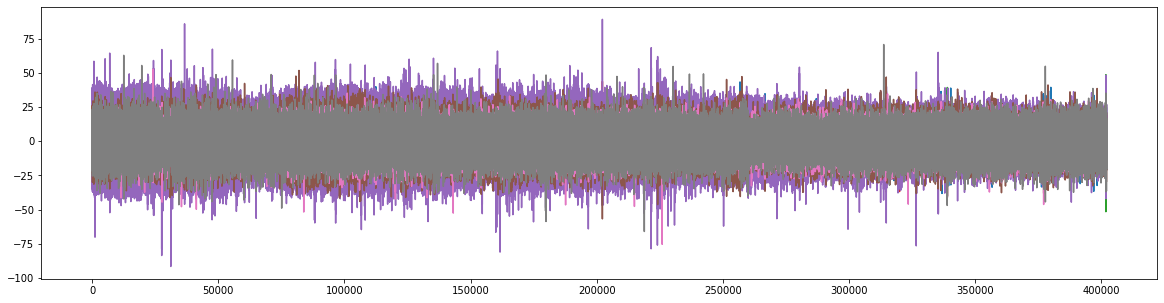

In [12]:
# clean up signal and plot - reconstruct parts with high amplitude noise such as eyeblinks
asr.calibrate(k = 15)
out = asr.clean(raw)
plt.figure(figsize=(20,5))
plt.plot(out.T);

In [13]:
#FEATURE EXTRACTION
#---------------

#concatenate data of same trials

Meditate = np.empty((8,0))
Stress = np.empty((8,0))



trial_offsets = range(0,len(raw.times), 80*250)
trial_len = 60*250

for i, o in enumerate(trial_offsets):
    if i<10:
        #print(i, o)
        Meditate = np.concatenate((Meditate, out[:, o: o+trial_len]), axis = 1)
    elif i<20:
        #print(i, o)
        Stress = np.concatenate((Stress, out[:, o: o+trial_len]), axis = 1)
    
        
print("amount of data: Meditate " + str(Meditate.shape[1]) + " Pos " + str(Stress.shape[1]))


amount of data: Meditate 150000 Pos 150000


In [14]:
def sliding_window(data, sf, win_len=2, win_overlap=0.66):
    #win_len and win_overlap in s!

    n_samples = data.shape[1]
    win_samples = int(win_len*sf)
    offsets = np.int_(np.arange(0,  n_samples - win_samples, np.round(win_samples * (1 - win_overlap))))

    #append window
    windows=[]
    for o in offsets:
        windows.append(data[:,o:o+win_samples])
                       
    return np.array(windows)

In [15]:
#create trials using sliding window

Med_windows = sliding_window(Meditate, 256)
Stress_windows = sliding_window(Stress, 256)
#Neg_windows = sliding_window(Neg, 256)

In [16]:
#create labels

labels = np.zeros((2, Med_windows.shape[0]+Stress_windows.shape[0]))
labels[0,:Med_windows.shape[0]]=1
labels[1,Med_windows.shape[0]:Med_windows.shape[0]+Stress_windows.shape[0]] =1

In [17]:
#concatenate all data

data = np.concatenate((Med_windows, Stress_windows), axis = 0)


In [18]:
#export data and labels
np.save("data_Eric.npy", data)
np.save("labels_Eric.npy", labels)

In [19]:
#CLASSIFICATION
#---------------


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#extract alpha

alpha = mne.filter.filter_data(data, 256, 5, 12)


X, y = shuffle(alpha, labels.T)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Setting up band-pass filter from 5 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 423 samples (1.652 sec)



In [20]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, ShuffleSplit

def train_riemann_ts(X_data, labels):
    # Riemannian Tangent Space Logistic Regression for EEG
    # After spatial filtering, covariances matrices are estimated, then projected in the tangent space and classified with a logistic regression.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

    # Define a unique pipeline to sequentially:
    clf = make_pipeline(
        Covariances(estimator='lwf'),
        TangentSpace(),
        LogisticRegression(solver='lbfgs'))

    scores = cross_validate(clf, X_data, labels, cv=cv, n_jobs=1, return_estimator=True, return_train_score=False)

    print('Mean: {0}, Std: {1}'.format(scores['test_score'].mean(), scores['test_score'].std()))

    # best_est = scores['estimator'][scores['test_score'].argmax()]
    best_est = clf.fit(X_data, labels)  # refit the estimator on the whole set

    return best_est

In [21]:
#Chance = 0.5!!
est = train_riemann_ts(X_train, np.argmax(y_train, axis=1))

Mean: 0.9434782608695652, Std: 0.008604595715244879


In [22]:
#plot_confusion_matrix(preds, labels, names)
#plt.show()

In [23]:
pred = est.predict(X_test)
true = np.argmax(y_test, axis=1)
n = len(pred)

print("accuracy on test: " + str(sum(pred == true)/n))


accuracy on test: 0.9302325581395349


In [24]:
import pickle
with open('trained_rieman.pkl', 'wb') as f:
    pickle.dump(est, f)